In [1]:
import numpy as np
from time import strftime

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def setup_model(exp_params):
    model = dict()
    model['tm'] = ec2b.TemporalModel(tsample=exp_params['tsample'])
    model['implant'] = e2cm.ArgusI(x_center=-5141, y_center=-449, h=100, rot=38*np.pi/180)
    model['retina'] = e2cm.Retina(sampling=exp_params['r_sampling'],
                                  xlo=-7500, xhi=-2500, ylo=-3000, yhi=2000,
                                  axon_lambda=exp_params['axon_lambda'],
                                  rot=exp_params['r_rot_deg']*np.pi/180)
    return model

In [3]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    name_E1 = exp_params['name_E1']
    name_E2 = exp_params['name_E2']
    
    # Set up currents and delays
    if idx_cond == 1:
        # Condition 1: E1 fixed, all others zero
        amp_E1 = [exp_params['amp_ref']]
        amp_E2 = np.zeros_like(amp_E1)
        delays = [0]
    elif idx_cond == 2:
         # Condition 2: E2 fixed, all others zero
        amp_E2 = [exp_params['amp_ref']]
        amp_E1 = np.zeros_like(amp_E2)
        delays = [0]
    elif idx_cond == 3:
        # Condition 3: E1 fixed, E2 varies
        # Make current sum to 75% - 125% of amp_ref
        amp_E2 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E1 = np.ones_like(amp_E2) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 4:
        # Condition 4: E2 fixed, E1 varies
        amp_E1 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E2 = np.ones_like(amp_E1) * 0.35 * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    elif idx_cond == 5:
        # Condition 5: Both E1 and E2 vary
        amp_E1 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        amp_E2 = np.linspace(0.3, 0.8, 3) * exp_params['amp_ref']
        delays = [0.075/1000, 0.375/1000, 1.8/1000, 9/1000]
    else:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    data['delay'] = []
    print ("- Condition %d" % idx_cond)
    for dd in delays:
        print("  - delay %.3f" % (dd*1000))
        
        for a1, a2 in zip(amp_E1, amp_E2):
            # generate list of pulse trains
            pt_e1 = get_pulse_train(a1, tsample=exp_params['tsample'])
            pt_e2 = get_pulse_train(a2, tsample=exp_params['tsample'], delay_dur=dd)
            pt = {name_E1: pt_e1, name_E2: pt_e2}
            resp = ec2b.pulse2percept(pt, model['implant'], model['tm'], model['retina'],
                                     use_ecs=exp_params['use_ecs'], n_jobs=8)

            # Find brightest frame
            brightest = ec2b.get_brightest_frame(resp)

            # Save data
            data['frames'].append(brightest)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            data['delay'].append(dd)
            
    return data

In [4]:
def run_experiment(exp_params, model):
    exp_params['date'] = strftime("%Y-%m-%d")
    print('Experiment: %s %s, %s' % (exp_params['name'], exp_params['name_E1'], exp_params['name_E2']))
    print('- Start time: %s %s' % (exp_params['date'], strftime("%H:%M:%S")))
    
    datapath = exp_params['save_dir']
    if not datapath.endswith('/'):
        datapath += '/'
    prefix = exp_params['name']
    electrodes = '%s_%s' % (exp_params['name_E1'], exp_params['name_E2'])
    suffix = '%s_%.1fX.npz' % (exp_params['date'], exp_params['fac_thresh'])

    # Check if we ran this experiment already
    import os
    for file in os.listdir(datapath):
        if file.startswith(prefix + '_' + electrodes):
            print('File that starts with %s%s_%s already exists, skip' % (datapath,
                                                                          prefix,
                                                                          electrodes))
            return

    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_%s_%s' % (datapath, prefix, electrodes, suffix)
    np.savez(filename, data=np.zeros(10))
    os.remove(filename)
    print('- File: %s' % filename)
    exp_params['filename'] = filename

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(5):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)
    print('- End time: %s' % strftime("%Y-%m-%d %H:%M:%S"))

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(amp, tsample, delay_dur=0):
    freq = 50
    pulse_dur = 0.45/1000
    stim_dur = 0.5
    return e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=stim_dur, delay=delay_dur,
                                  pulse_dur=pulse_dur, interphase_dur=pulse_dur)

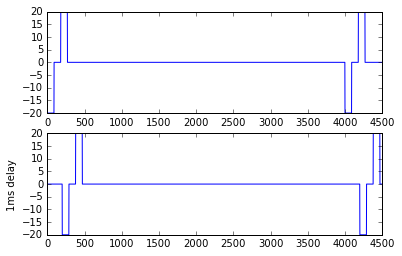

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 5e-6, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 5e-6, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

In [7]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'krishnan'

# sampling step in seconds
exp_params['tsample'] = 0.005 / 1000

# some factor x threshold
exp_params['fac_thresh'] = 1.5

# threshold current in micro amps
exp_params['amp_thresh'] = 15

# reference current at `fac_thresh` times threshold
exp_params['amp_ref'] = exp_params['fac_thresh'] * exp_params['amp_thresh']

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = True

exp_params['axon_lambda'] = 8
exp_params['r_sampling'] = 150
exp_params['r_rot_deg'] = 0
exp_params['integrationtype'] = 'dotproduct'

# where to save the data (relative path)
exp_params['save_dir'] = 'data/usability/lambda%s_rot%.0f_%.2fX/' % (exp_params['axon_lambda'],
                                                                     exp_params['r_rot_deg'],
                                                                     exp_params['fac_thresh'])

model = setup_model(exp_params)

In [8]:
# 13 different electrode pairs
name_E1 = ['C2','C1','A1','C3','C1','C3','B3','A4','B2','A2','B3','A1','A1','C4']
name_E2 = ['B2','D1','A2','C2','B1','B2','B2','B4','B4','C2','B1','C1','A4','C1']

for name1, name2 in zip(name_E1, name_E2):
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: krishnan C2, B2
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot0_1.50X/krishnan_C2_B2 already exists, skip
- Experiment took 0.0 s
Experiment: krishnan C1, D1
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot0_1.50X/krishnan_C1_D1 already exists, skip
- Experiment took 0.0 s
Experiment: krishnan A1, A2
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot0_1.50X/krishnan_A1_A2 already exists, skip
- Experiment took 0.0 s
Experiment: krishnan C3, C2
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot0_1.50X/krishnan_C3_C2 already exists, skip
- Experiment took 0.0 s
Experiment: krishnan C1, B1
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot0_1.50X/krishnan_C1_B1 already exists, skip
- Experiment took 0.0 s
Experiment: krishnan C3, B2
- Start time: 2016-12-08 18:55:26
File that starts with data/usability/lambda8_rot

JoblibLogicError: JoblibLogicError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f9e0db79b70, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/mbeyel.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f9e0db79b70, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/mbeyel.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    437         
    438         if self.poller is not None:
    439             self.poller.start()
    440         self.kernel.start()
    441         try:
--> 442             ioloop.IOLoop.instance().start()
    443         except KeyboardInterrupt:
    444             pass
    445 
    446 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    157             PollIOLoop.configure(ZMQIOLoop)
    158         return PollIOLoop.current(*args, **kwargs)
    159     
    160     def start(self):
    161         try:
--> 162             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    163         except ZMQError as e:
    164             if e.errno == ETERM:
    165                 # quietly return on ETERM
    166                 pass

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 5
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 5), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 5)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=5)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-08T18:55:26.531960', 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'session': 'DC51C6AB61A844198148738DE106A9D2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'DC51C6AB61A844198148738DE106A9D2']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-08T18:55:26.531960', 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'session': 'DC51C6AB61A844198148738DE106A9D2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'DC51C6AB61A844198148738DE106A9D2'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2016-12-08T18:55:26.531960', 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'session': 'DC51C6AB61A844198148738DE106A9D2', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '53D39BFCEF284C5798541B23560A6C80', 'msg_type': 'execute_request', 'parent_header': {}})
    386         if not silent:
    387             self.execution_count += 1
    388             self._publish_execute_input(code, parent, self.execution_count)
    389 
    390         reply_content = self.do_execute(code, silent, store_history,
--> 391                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    392 
    393         # Flush output before sending the reply.
    394         sys.stdout.flush()
    395         sys.stderr.flush()

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    194 
    195         reply_content = {}
    196         # FIXME: the shell calls the exception handler itself.
    197         shell._reply_content = None
    198         try:
--> 199             shell.run_cell(code, store_history=store_history, silent=silent)
        shell.run_cell = <bound method InteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)"
        store_history = True
        silent = False
    200         except:
    201             status = u'error'
    202             # FIXME: this code right now isn't being used yet by default,
    203             # because the run_cell() call above directly fires off exception

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)", store_history=True, silent=False, shell_futures=True)
   2718                 self.displayhook.exec_result = result
   2719 
   2720                 # Execute the user code
   2721                 interactivity = "none" if silent else self.ast_node_interactivity
   2722                 self.run_ast_nodes(code_ast.body, cell_name,
-> 2723                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2724 
   2725                 # Reset this so later displayed values do not modify the
   2726                 # ExecutionResult
   2727                 self.displayhook.exec_result = None

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.For object>], cell_name='<ipython-input-8-10a166a2105a>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2820 
   2821         try:
   2822             for i, node in enumerate(to_run_exec):
   2823                 mod = ast.Module([node])
   2824                 code = compiler(mod, cell_name, "exec")
-> 2825                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f9d895cbed0, file "<ipython-input-8-10a166a2105a>", line 5>
        result = <IPython.core.interactiveshell.ExecutionResult object>
   2826                     return True
   2827 
   2828             for i, node in enumerate(to_run_interactive):
   2829                 mod = ast.Interactive([node])

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f9d895cbed0, file "<ipython-input-8-10a166a2105a>", line 5>, result=<IPython.core.interactiveshell.ExecutionResult object>)
   2880         outflag = 1  # happens in more places, so it's easier as default
   2881         try:
   2882             try:
   2883                 self.hooks.pre_run_code_hook()
   2884                 #rprint('Running code', repr(code_obj)) # dbg
-> 2885                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f9d895cbed0, file "<ipython-input-8-10a166a2105a>", line 5>
        self.user_global_ns = {'In': ['', "import numpy as np\nfrom time import strftime\n\nfr...t as plt\nget_ipython().magic('matplotlib inline')", "def setup_model(exp_params):\n    model = dict()\n...p_params['r_rot_deg']*np.pi/180)\n    return model", "def run_condition(idx_cond, exp_params, model):\n...['delay'].append(dd)\n            \n    return data", 'def run_experiment(exp_params, model):\n    exp_p...\'- End time: %s\' % strftime("%Y-%m-%d %H:%M:%S"))', "# We could use ec2b.Psycho2Pulsetrain, but we'd ...   pulse_dur=pulse_dur, interphase_dur=pulse_dur)", "plt.subplot(211)\nplt.plot(get_pulse_train(20, 5e...-6, 1/1000).data[0:4500])\nplt.ylabel('1ms delay')", "exp_params = dict()\n\n# give the experiment a nam...s['fac_thresh'])\n\nmodel = setup_model(exp_params)", "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)"], 'Out': {6: <matplotlib.text.Text object>}, 'TimeSeries': <class 'pulse2percept.utils.TimeSeries'>, '_': <matplotlib.text.Text object>, '_6': <matplotlib.text.Text object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
        self.user_ns = {'In': ['', "import numpy as np\nfrom time import strftime\n\nfr...t as plt\nget_ipython().magic('matplotlib inline')", "def setup_model(exp_params):\n    model = dict()\n...p_params['r_rot_deg']*np.pi/180)\n    return model", "def run_condition(idx_cond, exp_params, model):\n...['delay'].append(dd)\n            \n    return data", 'def run_experiment(exp_params, model):\n    exp_p...\'- End time: %s\' % strftime("%Y-%m-%d %H:%M:%S"))', "# We could use ec2b.Psycho2Pulsetrain, but we'd ...   pulse_dur=pulse_dur, interphase_dur=pulse_dur)", "plt.subplot(211)\nplt.plot(get_pulse_train(20, 5e...-6, 1/1000).data[0:4500])\nplt.ylabel('1ms delay')", "exp_params = dict()\n\n# give the experiment a nam...s['fac_thresh'])\n\nmodel = setup_model(exp_params)", "# 13 different electrode pairs\nname_E1 = ['C2','...   print('- Experiment took %.1f s' % t_exe.best)"], 'Out': {6: <matplotlib.text.Text object>}, 'TimeSeries': <class 'pulse2percept.utils.TimeSeries'>, '_': <matplotlib.text.Text object>, '_6': <matplotlib.text.Text object>, '__': '', '___': '', '__builtin__': <module 'builtins' (built-in)>, '__builtins__': <module 'builtins' (built-in)>, '__doc__': 'Automatically created module for IPython interactive environment', ...}
   2886             finally:
   2887                 # Reset our crash handler in place
   2888                 sys.excepthook = old_excepthook
   2889         except SystemExit as e:

...........................................................................
/home/mbeyeler/pulse2percept/examples/notebooks/<ipython-input-8-10a166a2105a> in <module>()
      4 
      5 for name1, name2 in zip(name_E1, name_E2):
      6     exp_params['name_E1'] = name1
      7     exp_params['name_E2'] = name2
      8     
----> 9     t_exe = get_ipython().magic('timeit -oq -n1 -r1 run_experiment(exp_params, model)')
     10     print('- Experiment took %.1f s' % t_exe.best)
     11 
     12 
     13 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, arg_s='timeit -oq -n1 -r1 run_experiment(exp_params, model)')
   2158         compound statements.
   2159         """
   2160         # TODO: should we issue a loud deprecation warning here?
   2161         magic_name, _, magic_arg_s = arg_s.partition(' ')
   2162         magic_name = magic_name.lstrip(prefilter.ESC_MAGIC)
-> 2163         return self.run_line_magic(magic_name, magic_arg_s)
        self.run_line_magic = <bound method InteractiveShell.run_line_magic of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        magic_name = 'timeit'
        magic_arg_s = '-oq -n1 -r1 run_experiment(exp_params, model)'
   2164 
   2165     #-------------------------------------------------------------------------
   2166     # Things related to macros
   2167     #-------------------------------------------------------------------------

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_line_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='timeit', line='-oq -n1 -r1 run_experiment(exp_params, model)')
   2079             kwargs = {}
   2080             # Grab local namespace if we need it:
   2081             if getattr(fn, "needs_local_scope", False):
   2082                 kwargs['local_ns'] = sys._getframe(stack_depth).f_locals
   2083             with self.builtin_trap:
-> 2084                 result = fn(*args,**kwargs)
        result = undefined
        fn = <bound method ExecutionMagics.timeit of <IPython.core.magics.execution.ExecutionMagics object>>
        args = ['-oq -n1 -r1 run_experiment(exp_params, model)']
        kwargs = {}
   2085             return result
   2086 
   2087     def run_cell_magic(self, magic_name, line, cell):
   2088         """Execute the given cell magic.

...........................................................................
/home/mbeyeler/pulse2percept/examples/notebooks/<decorator-gen-59> in timeit(self=<IPython.core.magics.execution.ExecutionMagics object>, line='-oq -n1 -r1 run_experiment(exp_params, model)', cell=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.timeit>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '-oq -n1 -r1 run_experiment(exp_params, model)', None), **k={})
    188     validate_type(magic_kind)
    189 
    190     # This is a closure to capture the magic_kind.  We could also use a class,
    191     # but it's overkill for just that one bit of state.
    192     def magic_deco(arg):
--> 193         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.timeit>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '-oq -n1 -r1 run_experiment(exp_params, model)', None)
        k = {}
    194 
    195         if callable(arg):
    196             # "Naked" decorator call (just @foo, no args)
    197             func = arg

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in timeit(self=<IPython.core.magics.execution.ExecutionMagics object>, line='-oq -n1 -r1 run_experiment(exp_params, model)', cell=None)
   1041                 time_number = timer.timeit(number)
   1042                 worst_tuning = max(worst_tuning, time_number / number)
   1043                 if time_number >= 0.2:
   1044                     break
   1045                 number *= 10
-> 1046         all_runs = timer.repeat(repeat, number)
        all_runs = undefined
        timer.repeat = <bound method Timer.repeat of <IPython.core.magics.execution.Timer object>>
        repeat = 1
        number = 1
   1047         best = min(all_runs) / number
   1048 
   1049         worst = max(all_runs) / number
   1050         if worst_tuning:

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/timeit.py in repeat(self=<IPython.core.magics.execution.Timer object>, repeat=1, number=1)
    201         interested in.  After that, you should look at the entire
    202         vector and apply common sense rather than statistics.
    203         """
    204         r = []
    205         for i in range(repeat):
--> 206             t = self.timeit(number)
        t = undefined
        self.timeit = <bound method Timer.timeit of <IPython.core.magics.execution.Timer object>>
        number = 1
    207             r.append(t)
    208         return r
    209 
    210 def timeit(stmt="pass", setup="pass", timer=default_timer,

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in timeit(self=<IPython.core.magics.execution.Timer object>, number=1)
    132         """
    133         it = itertools.repeat(None, number)
    134         gcold = gc.isenabled()
    135         gc.disable()
    136         try:
--> 137             timing = self.inner(it, self.timer)
        timing = undefined
        self.inner = <function inner>
        it = repeat(None, 0)
        self.timer = <built-in function perf_counter>
    138         finally:
    139             if gcold:
    140                 gc.enable()
    141         return timing

...........................................................................
/home/mbeyeler/pulse2percept/examples/notebooks/<magic-timeit> in inner(_it=repeat(None, 0), _timer=<built-in function perf_counter>)
    252 
    253 
    254 
    255 
    256 
--> 257 
    258 
    259 
    260 
    261 

...........................................................................
/home/mbeyeler/pulse2percept/examples/notebooks/<ipython-input-4-da5f520ab8f5> in run_experiment(exp_params={'amp_ref': 22.5, 'amp_thresh': 15, 'axon_lambda': 8, 'date': '2016-12-08', 'fac_thresh': 1.5, 'filename': 'data/usability/lambda8_rot0_1.50X/krishnan_A1_A4_2016-12-08_1.5X.npz', 'integrationtype': 'dotproduct', 'name': 'krishnan', 'name_E1': 'A1', 'name_E2': 'A4', ...}, model={'implant': <pulse2percept.electrode2currentmap.ArgusI object>, 'retina': <pulse2percept.electrode2currentmap.Retina object>, 'tm': <pulse2percept.effectivecurrent2brightness.TemporalModel object>})
     29 
     30     # Run all 5 conditions
     31     data = dict()
     32     for idx_cond in range(5):
     33         name_cond = 'cond' + str(idx_cond + 1)
---> 34         data[name_cond] = run_condition(idx_cond + 1, exp_params, model)
     35 
     36     # Save results to .npz
     37     np.savez(filename, data=data, exp_params=exp_params, model=model)
     38     print('- Results saved to %s' % filename)

...........................................................................
/home/mbeyeler/pulse2percept/examples/notebooks/<ipython-input-3-8e89b844a975> in run_condition(idx_cond=1, exp_params={'amp_ref': 22.5, 'amp_thresh': 15, 'axon_lambda': 8, 'date': '2016-12-08', 'fac_thresh': 1.5, 'filename': 'data/usability/lambda8_rot0_1.50X/krishnan_A1_A4_2016-12-08_1.5X.npz', 'integrationtype': 'dotproduct', 'name': 'krishnan', 'name_E1': 'A1', 'name_E2': 'A4', ...}, model={'implant': <pulse2percept.electrode2currentmap.ArgusI object>, 'retina': <pulse2percept.electrode2currentmap.Retina object>, 'tm': <pulse2percept.effectivecurrent2brightness.TemporalModel object>})
     47             # generate list of pulse trains
     48             pt_e1 = get_pulse_train(a1, tsample=exp_params['tsample'])
     49             pt_e2 = get_pulse_train(a2, tsample=exp_params['tsample'], delay_dur=dd)
     50             pt = {name_E1: pt_e1, name_E2: pt_e2}
     51             resp = ec2b.pulse2percept(pt, model['implant'], model['tm'], model['retina'],
---> 52                                      use_ecs=exp_params['use_ecs'], n_jobs=8)
     53 
     54             # Find brightest frame
     55             brightest = ec2b.get_brightest_frame(resp)
     56 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/effectivecurrent2brightness.py in pulse2percept(stim={'A1': <pulse2percept.electrode2currentmap.Psycho2Pulsetrain object>, 'A4': <pulse2percept.electrode2currentmap.Psycho2Pulsetrain object>}, implant=<pulse2percept.electrode2currentmap.ArgusI object>, tm=<pulse2percept.effectivecurrent2brightness.TemporalModel object>, retina=<pulse2percept.electrode2currentmap.Retina object>, rsample=30, scale_charge=42.1, tol=0.05, use_ecs=True, engine='joblib', dojit=True, n_jobs=8, verbose=True)
    406     else:
    407         e_s = "Supported electrode types are 'epiretinal', 'subretinal'"
    408         raise ValueError(e_s)
    409 
    410     sr_list = utils.parfor(calc_pixel, ecs_list, n_jobs=n_jobs, engine=engine,
--> 411                            func_args=[pt_arr, tm, rsample, dolayer, dojit])
        pt_arr = array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]])
        tm = <pulse2percept.effectivecurrent2brightness.TemporalModel object>
        rsample = 30
        dolayer = 'NFL'
        dojit = True
    412     bm = np.zeros(retina.gridx.shape + (sr_list[0].data.shape[-1], ))
    413     idxer = tuple(np.array(idx_list)[:, i] for i in range(2))
    414     bm[idxer] = [sr.data for sr in sr_list]
    415     return utils.TimeSeries(sr_list[0].tsample, bm)

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/utils.py in parfor(func=<function calc_pixel>, in_list=[array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), array([[ 0.0310507 ,  0.03885029,  0.03135151,  ...  0.0937876 ,  0.14649218,
         0.22223433]]), array([[ 0.03471698,  0.0430852 ,  0.03324199,  ...  0.09591267,  0.14890473,
         0.22460465]]), array([[ 0.03907629,  0.04787195,  0.0350906 ,  ...  0.09731885,  0.15031484,
         0.22569223]]), array([[ 0.04430565,  0.05323848,  0.03683609,  ...  0.10007742,  0.15337286,
         0.2284687 ]]), array([[ 0.05063607,  0.05917523,  0.03840808,  ...  0.10162228,  0.15489852,
         0.22961745]]), array([[ 0.05836879,  0.06560858,  0.03973189,  ...  0.09731825,  0.15030023,
         0.22542082]]), array([[ 0.06789315,  0.0723675 ,  0.04073576,  ...  0.09904135,  0.15197154,
         0.22664845]]), array([[ 0.0796997 ,  0.0791508 ,  0.04135959,  ...  0.11032653,  0.16422721,
         0.23755456]]), array([[ 0.09437088,  0.085511  ,  0.04156347,  ...  0.11584545,  0.17033046,
         0.24272063]]), array([[ 0.11250583,  0.09087913,  0.04133391,  ...  0.11778353,  0.17213151,
         0.24396758]]), array([[ 0.1344886 ,  0.09465096,  0.04068608,  ...  0.12086655,  0.17542168,
         0.24652523]]), array([[ 0.15995569,  0.09632914,  0.0396613 ,  ...  0.12298981,  0.17733185,
         0.24779716]]), array([[ 0.18688278,  0.09567218,  0.03832063,  ...  0.13033021,  0.18541804,
         0.25437339]]), array([[ 0.21071179,  0.09277612,  0.03673622,  ...  0.13251569,  0.18725036,
         0.25543659]]), array([[ 0.22494986,  0.08804138,  0.03498269,  ...  0.14314863,  0.19814969,
         0.26400635]]), array([[ 0.22450533,  0.08204449,  0.03312998,  ...  0.14560392,  0.20017802,
         0.26523236]]), array([[ 0.20955143,  0.07538453,  0.03123868,  ...  0.14599185,  0.20014074,
         0.26443153]]), array([[ 0.18538056,  0.06856907,  0.02935778,  ...  0.14862793,  0.20222239,
         0.26563293]]), array([[ 0.15844008,  0.06196375,  0.02752435,  ...  0.1655038 ,  0.21997868,
         0.27969091]]), ...], out_shape=None, n_jobs=8, engine='joblib', backend='threading', func_args=[array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True], func_kwargs={})
    201         p = joblib.Parallel(n_jobs=n_jobs, backend=backend)
    202         d = joblib.delayed(func)
    203         d_l = []
    204         for in_element in in_list:
    205             d_l.append(d(in_element, *func_args, **func_kwargs))
--> 206         results = p(d_l)
        results = undefined
        d_l = [(<function calc_pixel>, (array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.0310507 ,  0.03885029,  0.03135151,  ...  0.0937876 ,  0.14649218,
         0.22223433]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.03471698,  0.0430852 ,  0.03324199,  ...  0.09591267,  0.14890473,
         0.22460465]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.03907629,  0.04787195,  0.0350906 ,  ...  0.09731885,  0.15031484,
         0.22569223]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.04430565,  0.05323848,  0.03683609,  ...  0.10007742,  0.15337286,
         0.2284687 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.05063607,  0.05917523,  0.03840808,  ...  0.10162228,  0.15489852,
         0.22961745]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.05836879,  0.06560858,  0.03973189,  ...  0.09731825,  0.15030023,
         0.22542082]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.06789315,  0.0723675 ,  0.04073576,  ...  0.09904135,  0.15197154,
         0.22664845]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.0796997 ,  0.0791508 ,  0.04135959,  ...  0.11032653,  0.16422721,
         0.23755456]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.09437088,  0.085511  ,  0.04156347,  ...  0.11584545,  0.17033046,
         0.24272063]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.11250583,  0.09087913,  0.04133391,  ...  0.11778353,  0.17213151,
         0.24396758]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.1344886 ,  0.09465096,  0.04068608,  ...  0.12086655,  0.17542168,
         0.24652523]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.15995569,  0.09632914,  0.0396613 ,  ...  0.12298981,  0.17733185,
         0.24779716]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.18688278,  0.09567218,  0.03832063,  ...  0.13033021,  0.18541804,
         0.25437339]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.21071179,  0.09277612,  0.03673622,  ...  0.13251569,  0.18725036,
         0.25543659]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.22494986,  0.08804138,  0.03498269,  ...  0.14314863,  0.19814969,
         0.26400635]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.22450533,  0.08204449,  0.03312998,  ...  0.14560392,  0.20017802,
         0.26523236]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.20955143,  0.07538453,  0.03123868,  ...  0.14599185,  0.20014074,
         0.26443153]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.18538056,  0.06856907,  0.02935778,  ...  0.14862793,  0.20222239,
         0.26563293]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.15844008,  0.06196375,  0.02752435,  ...  0.1655038 ,  0.21997868,
         0.27969091]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), ...]
    207     elif engine == 'dask':
    208         try:
    209             import dask
    210             import dask.multiprocessing

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=8), iterable=[(<function calc_pixel>, (array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.0310507 ,  0.03885029,  0.03135151,  ...  0.0937876 ,  0.14649218,
         0.22223433]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.03471698,  0.0430852 ,  0.03324199,  ...  0.09591267,  0.14890473,
         0.22460465]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.03907629,  0.04787195,  0.0350906 ,  ...  0.09731885,  0.15031484,
         0.22569223]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.04430565,  0.05323848,  0.03683609,  ...  0.10007742,  0.15337286,
         0.2284687 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.05063607,  0.05917523,  0.03840808,  ...  0.10162228,  0.15489852,
         0.22961745]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.05836879,  0.06560858,  0.03973189,  ...  0.09731825,  0.15030023,
         0.22542082]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.06789315,  0.0723675 ,  0.04073576,  ...  0.09904135,  0.15197154,
         0.22664845]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.0796997 ,  0.0791508 ,  0.04135959,  ...  0.11032653,  0.16422721,
         0.23755456]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.09437088,  0.085511  ,  0.04156347,  ...  0.11584545,  0.17033046,
         0.24272063]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.11250583,  0.09087913,  0.04133391,  ...  0.11778353,  0.17213151,
         0.24396758]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.1344886 ,  0.09465096,  0.04068608,  ...  0.12086655,  0.17542168,
         0.24652523]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.15995569,  0.09632914,  0.0396613 ,  ...  0.12298981,  0.17733185,
         0.24779716]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.18688278,  0.09567218,  0.03832063,  ...  0.13033021,  0.18541804,
         0.25437339]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.21071179,  0.09277612,  0.03673622,  ...  0.13251569,  0.18725036,
         0.25543659]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.22494986,  0.08804138,  0.03498269,  ...  0.14314863,  0.19814969,
         0.26400635]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.22450533,  0.08204449,  0.03312998,  ...  0.14560392,  0.20017802,
         0.26523236]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.20955143,  0.07538453,  0.03123868,  ...  0.14599185,  0.20014074,
         0.26443153]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.18538056,  0.06856907,  0.02935778,  ...  0.14862793,  0.20222239,
         0.26563293]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), (<function calc_pixel>, (array([[ 0.15844008,  0.06196375,  0.02752435,  ...  0.1655038 ,  0.21997868,
         0.27969091]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {}), ...])
    805             if pre_dispatch == "all" or n_jobs == 1:
    806                 # The iterable was consumed all at once by the above for loop.
    807                 # No need to wait for async callbacks to trigger to
    808                 # consumption.
    809                 self._iterating = False
--> 810             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=8)>
    811             # Make sure that we get a last message telling us we are done
    812             elapsed_time = time.time() - self._start_time
    813             self._print('Done %3i out of %3i | elapsed: %s finished',
    814                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
LogicError                                         Thu Dec  8 18:55:27 2016
PID: 4105                 Python 3.5.2: /home/mbeyeler/anaconda3/bin/python
...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function calc_pixel>, (array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True), {})]
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
     67     def __init__(self, iterator_slice):
     68         self.items = list(iterator_slice)
     69         self._size = len(self.items)
     70 
     71     def __call__(self):
---> 72         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function calc_pixel>
        args = (array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), <pulse2percept.effectivecurrent2brightness.TemporalModel object>, 30, 'NFL', True)
        kwargs = {}
     73 
     74     def __len__(self):
     75         return self._size
     76 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/effectivecurrent2brightness.py in calc_pixel(ecs_item=array([[ 0.02794126,  0.03512039,  0.02946884,  ...  0.09251167,  0.14519857,
         0.2212177 ]]), pt=array([[-22.5       , -22.49999948, -22.49999843...0.        ,
          0.        ,   0.        ]]), tm=<pulse2percept.effectivecurrent2brightness.TemporalModel object>, resample=30, dolayer='NFL', dojit=True)
    417 
    418 def calc_pixel(ecs_item, pt, tm, resample, dolayer,
    419                dojit=False):
    420     ecm = e2cm.ecm(ecs_item, pt, tm.tsample)
    421     # converts the current map to one that includes axon streaks
--> 422     sr = tm.model_cascade(ecm, dolayer, dojit=dojit)
        sr = undefined
        tm.model_cascade = <bound method TemporalModel.model_cascade of <pu...ffectivecurrent2brightness.TemporalModel object>>
        ecm = <pulse2percept.utils.TimeSeries object>
        dolayer = 'NFL'
        dojit = True
    423     sr.resample(resample)
    424     return sr
    425 
    426 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/effectivecurrent2brightness.py in model_cascade(self=<pulse2percept.effectivecurrent2brightness.TemporalModel object>, ecm=<pulse2percept.utils.TimeSeries object>, dolayer='NFL', dojit=True)
    254             np.maximum(-resp_nfl, 0)
    255         respA = self.lweight * np.maximum(resp_inl, 0) + \
    256             np.maximum(resp_nfl, 0)
    257         resp = respC + self.aweight * respA
    258         resp = self.stationary_nonlinearity(resp)
--> 259         resp = self.slow_response(resp)
        resp = array([ 0.        ,  0.00022507,  0.00044747, ...,  0.        ,
        0.        ,  0.        ])
        self.slow_response = <bound method TemporalModel.slow_response of <pu...ffectivecurrent2brightness.TemporalModel object>>
    260         return utils.TimeSeries(self.tsample, resp)
    261 
    262 
    263 def pulse2percept(stim, implant, tm=None, retina=None,

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/effectivecurrent2brightness.py in slow_response(self=<pulse2percept.effectivecurrent2brightness.TemporalModel object>, b4=array([ 0.        ,  0.00022507,  0.00044747, ...,  0.        ,
        0.        ,  0.        ]))
    199         sensitivity model.
    200 
    201         Conversion to TimeSeries is avoided for the sake of speedup.
    202         """
    203         if self.cu_slow is None:
--> 204             self.cu_slow = utils.CuFFTConvolve(b4.size, self.gamma_slow.size)
        self.cu_slow = None
        b4.size = 100000
        self.gamma_slow.size = 52500
    205 
    206         conv = self.cu_slow.cufftconvolve(b4, self.gamma_slow)
    207 
    208         # No need to zero-pad: fftconvolve already takes care of optimal

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pulse2percept-0.1.dev0-py3.5.egg/pulse2percept/utils.py in __init__(self=<pulse2percept.utils.CuFFTConvolve object>, in1size=100000, in2size=52500, mode='full', stream=None)
    310             self.out_size = in1size + in2size - 1
    311         else:
    312             raise ValueError("Acceptable mode flags are 'full'.")
    313 
    314         # Pre-allocate the zero-padding for the time-series of in1, in2
--> 315         self.x1_gpu = self.gpuarray.zeros(self.out_size, np.float32)
        self.x1_gpu = undefined
        self.gpuarray.zeros = <function zeros>
        self.out_size = 152499
    316         self.x2_gpu = self.gpuarray.zeros(self.out_size, np.float32)
    317 
    318         # Pre-allocate N//2+1 non-redundant FFT coefficients
    319         self.f1_gpu = self.gpuarray.empty(self.out_size // 2 + 1,

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py in zeros(shape=152499, dtype=<class 'numpy.float32'>, allocator=<Boost.Python.function object>, order='C')
    988 
    989 
    990 def zeros(shape, dtype, allocator=drv.mem_alloc, order="C"):
    991     """Returns an array of the given shape and dtype filled with 0's."""
    992 
--> 993     result = GPUArray(shape, dtype, allocator, order=order)
        result = undefined
        shape = 152499
        dtype = <class 'numpy.float32'>
        allocator = <Boost.Python.function object>
        order = 'C'
    994     zero = np.zeros((), dtype)
    995     result.fill(zero)
    996     return result
    997 

...........................................................................
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py in __init__(self=<class 'pycuda.gpuarray.GPUArray'> instance, shape=(152499,), dtype=dtype('float32'), allocator=<Boost.Python.function object>, base=None, gpudata=None, strides=(4,), order='C')
    204         self.nbytes = self.dtype.itemsize * self.size
    205 
    206         self.allocator = allocator
    207         if gpudata is None:
    208             if self.size:
--> 209                 self.gpudata = self.allocator(self.size * self.dtype.itemsize)
        self.gpudata = undefined
        self.allocator = <Boost.Python.function object>
        self.size = 152499
        self.dtype.itemsize = 4
    210             else:
    211                 self.gpudata = None
    212 
    213             assert base is None

LogicError: cuMemAlloc failed: invalid device context
___________________________________________________________________________